In [1]:
'''
Import helper_functions 
'''
from helper_functions import (split_X_y, split_num_cat, forecasting_result, show_scores, APE, plot_histogram, 
                              fill_na_inf, calculating_kWh, plot_kWh, loss_acc_epochs, plot_pv, 
                              model_checkpoint, early_stop)

2024-11-28 15:37:19.057842: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 15:37:19.136724: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 15:37:19.136784: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 15:37:19.136872: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 15:37:19.164801: I tensorflow/core/platform/cpu_feature_g

# Import historical dataset

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

original_df = pd.read_csv('../Dataset/hist_data.csv', 
                 index_col='timestamp_local', encoding='utf-8-sig', parse_dates=['timestamp_local'])

original_df.shape

(128832, 26)

In [5]:
'''
====================================
The imported dataset is already passed two preprocessing steps 

1. Remove timesteps with zero PV power output during daytime
2. Add sun position angles
====================================
'''
original_df.head(2)

,precip_rate,rh,wind_spd,timestamp_utc,snow_rate,app_temp,pres,azimuth,dewpt,uv,...,vis,dni,temp,slp,clouds,ts,PV_Power,declination_angle,altitude_angle,azimuth_angle
timestamp_local,,,,,,,,,,,,,,,,,,,,,
2016-01-04 00:00:00,0.0,61.0,1.6,2016-01-03 17:00:00,0.0,28.2,1014.76575,209.44,18.8,0.0,...,10.0,0.0,27.0,1015.0,25.0,1.451840e+09,0.0,-0.39703,-1.41642,0.00000
2016-01-04 00:15:00,0.0,63.0,1.6,2016-01-03 17:15:00,0.0,28.3,1014.76570,191.08,19.4,0.0,...,10.0,0.0,27.0,1015.0,25.0,1.451841e+09,0.0,-0.39703,-1.40442,0.37278


# Preprocessing data
### 1. Filter daytime timestamp

In [6]:
dt_fil_df = original_df[(original_df.index.time >= datetime.time(6,0)) & (original_df.index.time <= datetime.time(18,0))]
dt_fil_df.shape

(65758, 26)

In [7]:
print(f'Daytime filter has {dt_fil_df.shape[0]} samples, presenting {(dt_fil_df.shape[0] * 100 / original_df.shape[0]):.2f} % from original df')
print(f'Daytime filter df has {dt_fil_df.loc["2016-01-04"].shape[0]} samples per day')
df = dt_fil_df

Daytime filter has 65758 samples, presenting 51.04 % from original df
Daytime filter df has 49 samples per day


### 2. Features selections and arrange columns to extract spatial features 

In [8]:
'''
Arrange correlated columns:
`Irradiance` => `Temperatures` => `visibility` => 'Wind & humidity' => 'Sun Position' => 'PV_Power (y)' => Unused columns
'''
arr_cols = ['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh',       
            'app_temp', 'temp', 'dewpt', 
            'clouds', 'vis',             
            'wind_spd', 'wind_dir', 
            'declination_angle', 'altitude_angle', 'azimuth_angle',
            'PV_Power',
            'weather', 'precip_rate',   'timestamp_utc', 'snow_rate', 'pres', 'azimuth', 'elev_angle', 'slp', 'ts']

df = df[arr_cols]
df.columns

Index(['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp',
       'dewpt', 'clouds', 'vis', 'wind_spd', 'wind_dir', 'declination_angle',
       'altitude_angle', 'azimuth_angle', 'PV_Power', 'weather', 'precip_rate',
       'timestamp_utc', 'snow_rate', 'pres', 'azimuth', 'elev_angle', 'slp',
       'ts'],
      dtype='object')

In [9]:
# Split X columns into categorical and numerical 
categorical_columns, numerical_columns = split_num_cat(df)
print(f'Categorical columns : {categorical_columns} \n')
print(f'Numerical columns : {numerical_columns}')

Categorical columns : ['weather', 'timestamp_utc'] 

Numerical columns : ['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp', 'dewpt', 'clouds', 'vis', 'wind_spd', 'wind_dir', 'declination_angle', 'altitude_angle', 'azimuth_angle', 'PV_Power', 'precip_rate', 'snow_rate', 'pres', 'azimuth', 'elev_angle', 'slp', 'ts']


In [10]:
'''
Disgard columns which will not be used for forecasting
'''
y_col = ['PV_Power']

ignored_cols = ['dewpt', 'clouds', 'vis', 'precip_rate', 'azimuth', 'elev_angle', 
                'snow_rate', 'ts', 'pres', 'wind_dir', 'slp'] + categorical_columns 
print(f'Ignored columns : {ignored_cols}')

Ignored columns : ['dewpt', 'clouds', 'vis', 'precip_rate', 'azimuth', 'elev_angle', 'snow_rate', 'ts', 'pres', 'wind_dir', 'slp', 'weather', 'timestamp_utc']


In [11]:
# Split datasets by time
training_set = df.sort_index().loc[:'2018-09'] # Training set (2 years and 9 months) = 68%
val_set = df.sort_index().loc['2018-10':'2018-12'] # Validation set (3 months) = 7%
test_set = df.sort_index().loc['2019':] # Test set (1 year) = 25%

# Split `X` and `y`
X_train, y_train = split_X_y(training_set, ignored_cols)
X_val, y_val = split_X_y(val_set, ignored_cols)
X_test, y_test = split_X_y(test_set, ignored_cols)


X_cols = X_train.columns
print(f'List of X columns: \n{list(X_cols)} \n')
print(f'Total of X columns: \n{len(X_cols)}')

List of X columns: 
['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp', 'wind_spd', 'declination_angle', 'altitude_angle', 'azimuth_angle'] 

Total of X columns: 
12


In [12]:
## Time peroid of each dataset. 
print(
    f'''
    Training set is from {X_train.index.min()} to {X_train.index.max()} 
    Validation set is from {X_val.index.min()} to {X_val.index.max()} 
    Test set is from {X_test.index.min()} to {X_test.index.max()}
    ''')


    Training set is from 2016-01-04 06:00:00 to 2018-09-30 18:00:00 
    Validation set is from 2018-10-01 06:00:00 to 2018-12-31 18:00:00 
    Test set is from 2019-01-01 06:00:00 to 2019-12-31 18:00:00
    


### 3. Rescale numerical columns

In [13]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler

# Manage columns for Standardize processes
non_std_cols = ['declination_angle', 'altitude_angle', 'azimuth_angle']

selected_cols = list(map(lambda x : x not in non_std_cols, X_cols))
std_cols = X_cols[selected_cols]
print(f'Total of columns to rescale: \n{len(std_cols)}')
print(f'Columns to rescale are: {list(std_cols)} \n')

ct = make_column_transformer((MaxAbsScaler(), std_cols), remainder='passthrough')

ct.fit(X_train)

std_X_train = ct.transform(X_train)
std_X_val = ct.transform(X_val)
std_X_test = ct.transform(X_test)

std_X_train.shape, y_train.shape, std_X_val.shape, y_val.shape, std_X_test.shape, y_test.shape

Total of columns to rescale: 
9
Columns to rescale are: ['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp', 'wind_spd'] 



((44982, 12), (44982,), (4312, 12), (4312,), (16464, 12), (16464,))

In [14]:
'''
Check data type of all dataset
'''
std_X_train.dtype, y_train.dtype, std_X_val.dtype, y_val.dtype, std_X_test.dtype, y_test.dtype

(dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'))

In [15]:
print(f"training set = {np.round(std_X_train.shape[0] / df.shape[0], 2)}")
print(f"validation set = {np.round(std_X_val.shape[0] / df.shape[0], 2)}")
print(f"test set = {np.round(std_X_test.shape[0] / df.shape[0], 2)}")
print(f'total datapoints = {std_X_train.shape[0] + std_X_val.shape[0] + std_X_test.shape[0]}')

training set = 0.68
validation set = 0.07
test set = 0.25
total datapoints = 65758


### 4. Arrange sequences of historical weather data

In [18]:
'''
Historical data is recorded every 15 minutes (15 mins/sample). 
'''
sequence_size = 5
forecast_ahead = 10

window_size = df.loc["2016-01-04"].shape[0] * sequence_size
forecast_range = df.loc["2016-01-04"].shape[0] * (forecast_ahead-1)

def sequenceData(Input, Output, window_size, forecast_range):
    X, y = [], []
    for i in range(len(Input) - window_size - forecast_range):
        seq = i + window_size
        X.append(Input[i:seq])
        y.append(Output[seq + forecast_range])        
    return np.array(X), np.array(y)

seq_X_train, seq_y_train = sequenceData(std_X_train, y_train, window_size, forecast_range)
seq_X_val, seq_y_val = sequenceData(std_X_val, y_val, window_size, forecast_range)
seq_X_test, seq_y_test = sequenceData(std_X_test, y_test, window_size, forecast_range)

/tmp/ipykernel_17639/1103906657.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(Output[seq + forecast_range])


In [19]:
print('======== Data Shape ======== \n'
    f'Training set: X = {seq_X_train.shape}, y = {seq_y_train.shape} \n'
     f'Validation set: X = {seq_X_val.shape}, y = {seq_y_val.shape} \n'
     f'Test set: X = {seq_X_test.shape}, y = {seq_y_test.shape} \n'
      f'Total samples in a day = {df.loc["2016-01-04"].shape[0]} \n'
     f'window size = {window_size}\n'
     f'forecast ahead = {forecast_ahead} days')

total_X_cols = len(X_cols)

======== Data Shape ======== 
Training set: X = (44296, 245, 12), y = (44296,) 
Validation set: X = (3626, 245, 12), y = (3626,) 
Test set: X = (15778, 245, 12), y = (15778,) 
Total samples in a day = 49 
window size = 245
forecast ahead = 10 days


# Setup environment
### 1. Check CPU and GPU available

In [16]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version = " + tf.__version__)

Num GPUs Available:  1
Tensorflow version = 2.14.0


2024-11-28 15:41:28.973866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 15:41:29.170665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 15:41:29.170719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### 2. Set random seed and state

In [17]:
import os, random
import tensorflow as tf

def set_seed(seed_value=20):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

# Building forecast models

### 1. Long-Short Term Memory (LSTM)

In [20]:
from keras import Model
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, Reshape, Input, Activation
from keras.optimizers import SGD, Adam

set_seed()
input_shape = seq_X_train.shape[1:]

# Structure model
inputs = Input(shape=input_shape, name='model_input')

x = LSTM(192, return_sequences=True, activation='tanh', dropout=0.1, name='1st_LSTM')(inputs)
x = LSTM(96, activation='tanh', dropout=0.1, name='2nd_LSTM')(x)
x = Dense(192, activation='relu', name='1st_dense')(x)
x = Dense(96, activation='relu', name='2nd_dense')(x)
x = Dense(48, activation='relu', name='3rd_dense')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

output = Dense(1, activation='relu', name='model_output')(x)
LSTM_model = Model(inputs=inputs, outputs=output, name='LSTM_model')

# Configure optimizer
lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_rate=1e-6, decay_steps=1, staircase=False)
opt = Adam(learning_rate=lr_scheduler)

# Define an optimizer and loss metric
LSTM_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error'])

LSTM_model.summary()

2024-11-28 15:48:13.812770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 15:48:13.812864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 15:48:13.812893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 15:48:13.940044: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 15:48:13.940111: I tensorflow/compile

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 245, 12)]         0         
                                                                 
 1st_LSTM (LSTM)             (None, 245, 192)          157440    
                                                                 
 2nd_LSTM (LSTM)             (None, 96)                110976    
                                                                 
 1st_dense (Dense)           (None, 192)               18624     
                                                                 
 2nd_dense (Dense)           (None, 96)                18528     
                                                                 
 3rd_dense (Dense)           (None, 48)                4656      
                                                                 
 batch_normalization (Batch  (None, 48)                1

In [21]:
set_seed()
'''
===================
Initial train model 
===================
'''
init_epochs = 10
Batch = 32

with tf.device('/GPU:0'):
    LSTM_history = LSTM_model.fit(x=seq_X_train, y=seq_y_train,
                                  epochs=init_epochs, batch_size=Batch,
                                  validation_data=(seq_X_val, seq_y_val), verbose=1)

Epoch 1/10


2024-11-28 15:48:59.851084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-28 15:49:00.507492: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa05c2485d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-28 15:49:00.507535: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-11-28 15:49:00.515234: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-28 15:49:00.618690: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1385/1385 [==============================] - 63s 42ms/step - loss: 2891.4631 - mean_absolute_error: 2891.4631 - val_loss: 2247.7861 - val_mean_absolute_error: 2247.7861
Epoch 2/10
1385/1385 [==============================] - 53s 38ms/step - loss: 2481.6025 - mean_absolute_error: 2481.6025 - val_loss: 1777.1219 - val_mean_absolute_error: 1777.1219
Epoch 3/10
1385/1385 [==============================] - 54s 39ms/step - loss: 1900.2512 - mean_absolute_error: 1900.2512 - val_loss: 1280.3770 - val_mean_absolute_error: 1280.3770
Epoch 4/10
1385/1385 [==============================] - 55s 39ms/step - loss: 1383.9858 - mean_absolute_error: 1383.9858 - val_loss: 851.1839 - val_mean_absolute_error: 851.1839
Epoch 5/10
1385/1385 [==============================] - 54s 39ms/step - loss: 1101.6395 - mean_absolute_error: 1101.6395 - val_loss: 754.1306 - val_mean_absolute_error: 754.1306
Epoch 6/10
1385/1385 [==============================] - 56s 41ms/step - loss: 1032.2347 - mean_absolute_error: 1032

#### Evaluate forecast results

In [22]:
LSTM_val_result = forecasting_result(LSTM_model, seq_X_val)
LSTM_test_result = forecasting_result(LSTM_model, seq_X_test)

494/494 [==============================] - 8s 16ms/step


In [23]:
# Evaluate scores on the validation dataset
LSTM_val_scores = show_scores(LSTM_val_result, seq_y_val)

Mean Absolute Error = 805.36 W 
Root Mean Squared Error = 1283.09 W 
Mean Bias Error = 517.08 W 
 
Normalized_MAE (installed_Power) = 8.05% 
Normalized_RMSE (installed_Power) = 12.83% 
 
Normalized_MAE (avg_Power) = 32.47% 
Normalized_RMSE (avg_Power) = 51.72% 
 
Peak PV output power (from y_test) = 7647.67 W 
Average PV output power (from y_test) = 2480.68 W


In [24]:
# Evaluate scores on the test dataset
LSTM_test_scores = show_scores(LSTM_test_result, seq_y_test)

Mean Absolute Error = 910.93 W 
Root Mean Squared Error = 1346.53 W 
Mean Bias Error = 341.25 W 
 
Normalized_MAE (installed_Power) = 9.11% 
Normalized_RMSE (installed_Power) = 13.47% 
 
Normalized_MAE (avg_Power) = 29.44% 
Normalized_RMSE (avg_Power) = 43.52% 
 
Peak PV output power (from y_test) = 9875.00 W 
Average PV output power (from y_test) = 3093.70 W


#### Plot loss curve

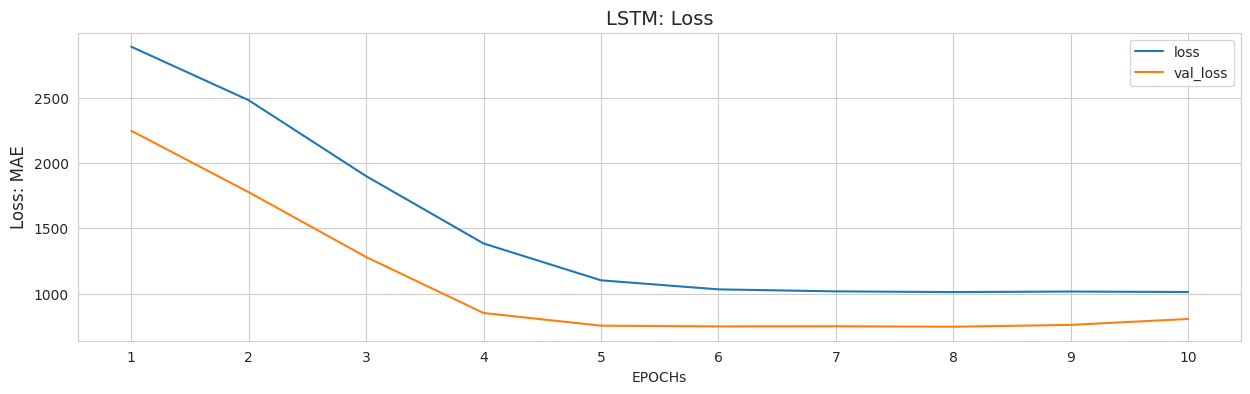

In [25]:
loss_acc_epochs(LSTM_history, 'LSTM', 'MAE')

### 2. Convolutional Neural Networks and Long Short-Term Memory (CNN + LSTM)

In [26]:
from keras import Model
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, Conv1D, Reshape, Input, Activation, Conv2D
from keras.optimizers import SGD, Adam

set_seed()

# Structure model
inputs = Input(shape=(*seq_X_train.shape[1:], 1), name='model_input')

## Conv2D
x = Conv2D(32, kernel_size=(1, 3), strides=(1, 1), padding='valid', activation='relu', name='1st_Conv2D')(inputs)
x = Conv2D(1, kernel_size=(1, 3), strides=(1, 1), padding='valid', activation='relu', name='2nd_Conv2D')(x)
x = Reshape(target_shape=(x.shape[1:-1]))(x)

## LSTM and Dense
x = LSTM(96, return_sequences=True, activation='tanh', dropout=0.1, name='1st_LSTM')(x)
x = LSTM(48, activation='tanh', dropout=0.1, name='2nd_LSTM')(x)
x = Dense(64, activation='relu', name='1st_dense')(x)
x = Dense(32, activation='relu', name='2nd_dense')(x)
# x = Dense(48, activation='relu', name='3rd_dense')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

output = Dense(1, activation='relu', name='model_output')(x)
CNNLSTM_model = Model(inputs=inputs, outputs=output, name='CNNLSTM_model')

# Configure optimizer
lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_rate=1e-6, decay_steps=1, staircase=False)
opt = Adam(learning_rate=lr_scheduler)

# define an optimizer and loss measure
CNNLSTM_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error'])

CNNLSTM_model.summary()

Model: "CNNLSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 245, 12, 1)]      0         
                                                                 
 1st_Conv2D (Conv2D)         (None, 245, 10, 32)       128       
                                                                 
 2nd_Conv2D (Conv2D)         (None, 245, 8, 1)         97        
                                                                 
 reshape (Reshape)           (None, 245, 8)            0         
                                                                 
 1st_LSTM (LSTM)             (None, 245, 96)           40320     
                                                                 
 2nd_LSTM (LSTM)             (None, 48)                27840     
                                                                 
 1st_dense (Dense)           (None, 64)              

In [27]:
set_seed()
'''
===================
Initial train model 
===================
'''
init_epochs = 5
Batch = 32

with tf.device('/GPU:0'):
    CNNLSTM_history = CNNLSTM_model.fit(x=seq_X_train, y=seq_y_train,
                                        epochs=init_epochs, batch_size=Batch,
                                        validation_data=(seq_X_val, seq_y_val), verbose=1)

Epoch 1/5
1385/1385 [==============================] - 64s 42ms/step - loss: 2916.4438 - mean_absolute_error: 2916.4438 - val_loss: 2322.9541 - val_mean_absolute_error: 2322.9541
Epoch 2/5
1385/1385 [==============================] - 57s 41ms/step - loss: 2629.3508 - mean_absolute_error: 2629.3508 - val_loss: 1914.3890 - val_mean_absolute_error: 1914.3890
Epoch 3/5
1385/1385 [==============================] - 57s 41ms/step - loss: 2190.7891 - mean_absolute_error: 2190.7891 - val_loss: 1444.8455 - val_mean_absolute_error: 1444.8455
Epoch 4/5
1385/1385 [==============================] - 56s 41ms/step - loss: 1725.8510 - mean_absolute_error: 1725.8510 - val_loss: 1063.8088 - val_mean_absolute_error: 1063.8088
Epoch 5/5
1385/1385 [==============================] - 57s 41ms/step - loss: 1337.0333 - mean_absolute_error: 1337.0333 - val_loss: 938.9310 - val_mean_absolute_error: 938.9310


#### Evaluate forecast results

In [28]:
CNNLSTM_val_result = forecasting_result(CNNLSTM_model, seq_X_val)
CNNLSTM_test_result = forecasting_result(CNNLSTM_model, seq_X_test)

494/494 [==============================] - 9s 18ms/step


In [29]:
# Evaluate scores on the validation dataset
CNNLSTM_val_scores = show_scores(CNNLSTM_val_result, seq_y_val)

Mean Absolute Error = 938.93 W 
Root Mean Squared Error = 1254.71 W 
Mean Bias Error = -554.33 W 
 
Normalized_MAE (installed_Power) = 9.39% 
Normalized_RMSE (installed_Power) = 12.55% 
 
Normalized_MAE (avg_Power) = 37.85% 
Normalized_RMSE (avg_Power) = 50.58% 
 
Peak PV output power (from y_test) = 7647.67 W 
Average PV output power (from y_test) = 2480.68 W


In [30]:
# Evaluate scores on the test dataset
CNNLSTM_test_scores = show_scores(CNNLSTM_test_result, seq_y_test)

Mean Absolute Error = 1287.55 W 
Root Mean Squared Error = 1704.85 W 
Mean Bias Error = -1047.26 W 
 
Normalized_MAE (installed_Power) = 12.88% 
Normalized_RMSE (installed_Power) = 17.05% 
 
Normalized_MAE (avg_Power) = 41.62% 
Normalized_RMSE (avg_Power) = 55.11% 
 
Peak PV output power (from y_test) = 9875.00 W 
Average PV output power (from y_test) = 3093.70 W


#### Plot loss curve

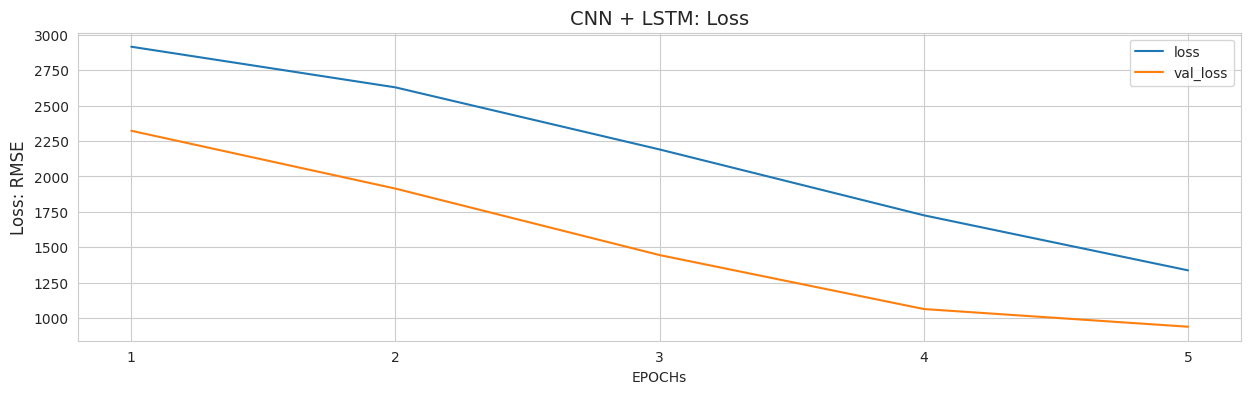

In [31]:
loss_acc_epochs(CNNLSTM_history, 'CNN + LSTM', 'RMSE')

## Comparing the model's accuracy

In [32]:
seq_models_scores = pd.DataFrame([LSTM_test_scores, CNNLSTM_test_scores], 
                                 index=['LSTM', 'CNN + LSTM']).round(2)
seq_models_scores

,MAE,RMSE,MBE,NMAE_installed,NRMSE_installed,NMAE_avg,NRMSE_avg
LSTM,910.929993,1346.530029,341.25,9.11,13.47,29.44,43.52
CNN + LSTM,1287.550049,1704.849976,-1047.26,12.88,17.05,41.62,55.11
